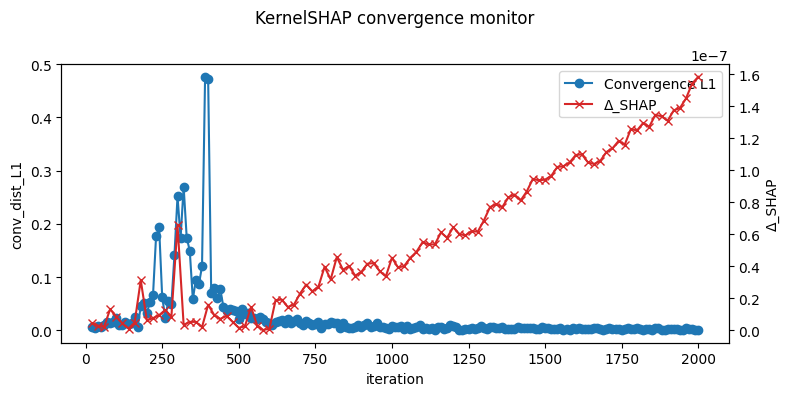

In [50]:
import json
from pathlib import Path
import matplotlib.pyplot as plt


# ------------------------------------------------------------------ #
# 1.  Parse log, de-duplicate by overwriting on the same iteration   #
# ------------------------------------------------------------------ #
def load_metrics_nodupe(log_path):
    conv_dict, delta_dict = {}, {}          # {iter: value}

    with Path(log_path).open() as fp:
        for ln in fp:
            rec = json.loads(ln)
            it = rec["iter"]
            if "conv_dist_L1" in rec:
                conv_dict[it] = rec["conv_dist_L1"]
            if "delta_shap" in rec:
                delta_dict[it] = rec["delta_shap"]

    # sort into lists
    it_conv   = sorted(conv_dict)
    conv_vals = [conv_dict[i]   for i in it_conv]

    it_delta  = sorted(delta_dict)
    delta_vals= [delta_dict[i]  for i in it_delta]

    return (it_conv, conv_vals), (it_delta, delta_vals)


# ------------------------------------------------------------------ #
# 2.  Plot with shared x, two y-axes                                  #
# ------------------------------------------------------------------ #
def plot_conv_delta(conv, delta, title=None):
    it_conv, conv_vals   = conv
    it_delta, delta_vals = delta

    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.set_xlabel("iteration")
    ax1.set_ylabel("conv_dist_L1")
    ax1.plot(it_conv, conv_vals, marker="o", label="Convergence L1")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Δ_SHAP")
    ax2.plot(it_delta, delta_vals, marker="x", color="tab:red", label="Δ_SHAP")

    # legend combining both axes
    lines  = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right")

    if title:
        fig.suptitle(title)
    fig.tight_layout()
    return fig


# ------------------------------------------------------------------ #
# Example usage                                                      #
# ------------------------------------------------------------------ #
log_file = "monitor_log-5.jsonl"          # your log path
conv, delta = load_metrics_nodupe(log_file)

fig = plot_conv_delta(conv, delta, title="KernelSHAP convergence monitor")
plt.show()


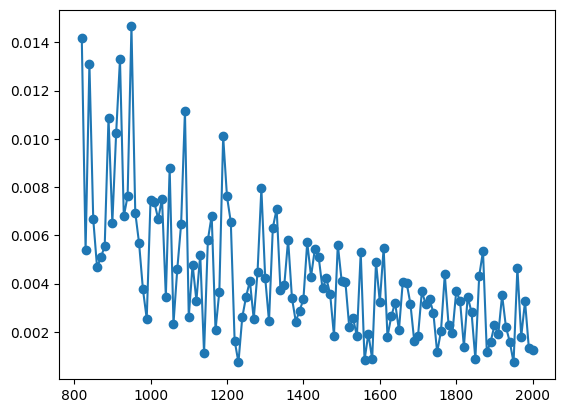

In [51]:
it_conv, conv_vals = conv
plt.plot(it_conv[80:], conv_vals[80:], marker="o", label="Convergence L1")

In [52]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
ds_path = 'dataset-39.pkl'  # Path to your dataset file

with open(ds_path, 'rb') as f:
    ds = CPU_Unpickler(f).load()

# If the dataset is a DataLoader, extract the dataset
if isinstance(ds, DataLoader):
    ds = ds.dataset

# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(20, X.shape[0]+1, 20)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([4000, 384]), y=torch.Size([4000]), w=torch.Size([4000])
Output range: [0.000000, 0.007281]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n=  20: delta=3.73e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.02e+04

n=  40: delta=9.31e-10, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.10e+04

n=  60: delta=2.79e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 2.21e+04

n=  80: delta=2.33e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 3.61e+04

n= 100: delta=9.31e-10, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214,


=== Investigating around iteration 250==


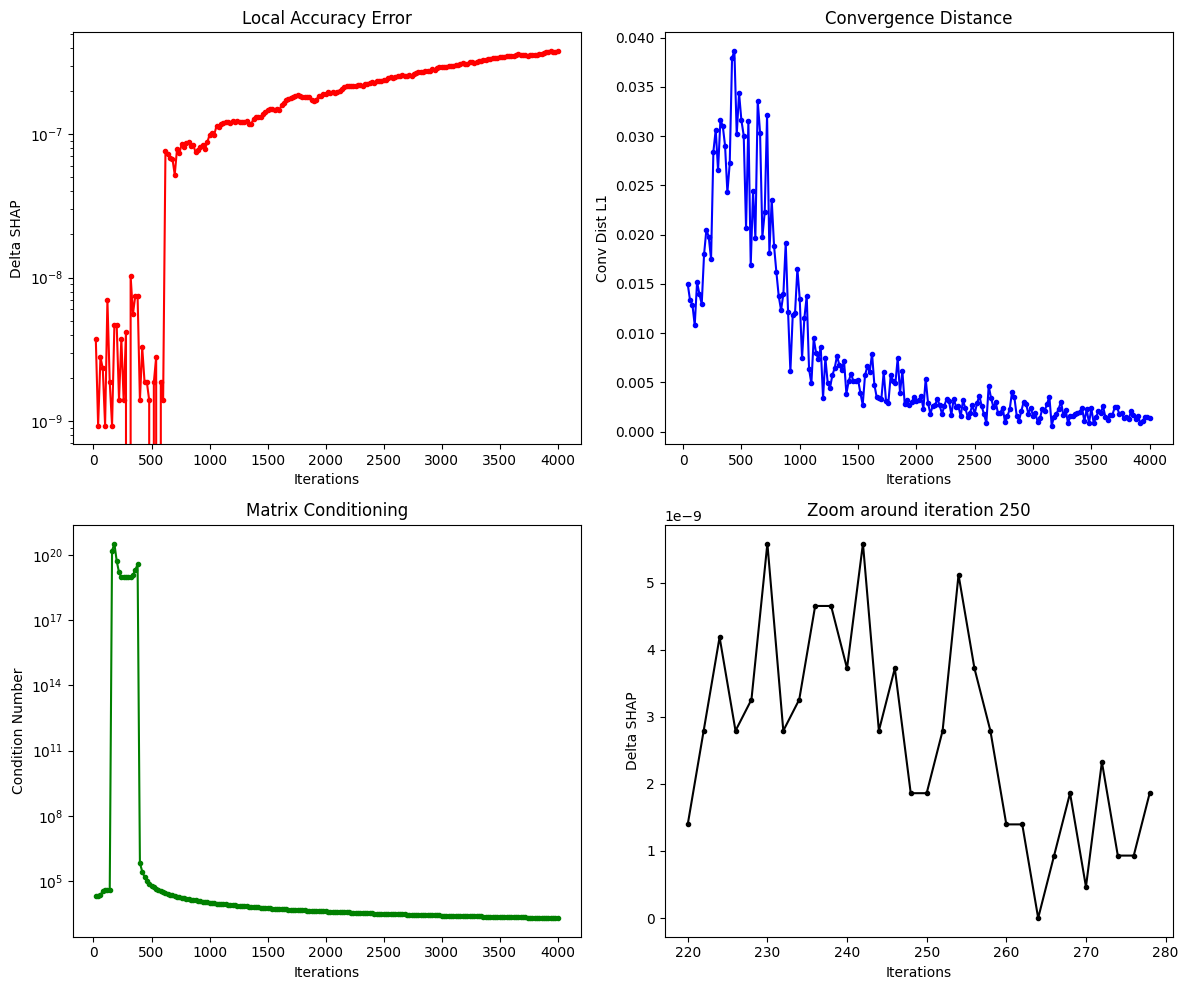


=== Additional Analysis ===
Number of unique samples: 3837
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 292
Samples with exactly 5 features active: 76
Samples with exactly 10 features active: 37
Samples with exactly 50 features active: 8
Samples with exactly 100 features active: 3
Samples with exactly 383 features active: 292

=== Samples around position 170 ===

=== Output distribution ===
Min 5 outputs: tensor([0., 0., 0., 0., 0.])
Max 5 outputs: tensor([0.0073, 0.0073, 0.0073, 0.0073, 0.0073])

=== Output distribution ===
Min 5 outputs: tensor([0., 0., 0., 0., 0.])
Max 5 outputs: tensor([0.0073, 0.0073, 0.0073, 0.0073, 0.0073])

=== Output distribution ===
Min 5 outputs: tensor([0., 0., 0., 0., 0.])
Max 5 outputs: tensor([0.0073, 0.0073, 0.0073, 0.0073, 0.0073])

=== Output distribution ===
Min 5 outputs: tensor([0., 0., 0., 0., 0.])
Max 5 outputs: tensor([0.0073, 0.0073, 0.0073, 0.0073, 0.0073])

=== O

In [53]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
print("\n=== Investigating around iteration 250==")
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    # Check if there are any extreme outliers in outputs
    print(f"\n=== Output distribution ===")
    sorted_outputs = torch.sort(y)[0]
    print(f"Min 5 outputs: {sorted_outputs[:5]}")
    print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [54]:
print("condition numbers:")
print(len(condition_numbers))
print(checkpoints)
print([(i, condition_numbers[i//20-1]) for i in checkpoints])

condition numbers:
200
range(20, 4001, 20)
[(20, np.float64(20216.697763815722)), (40, np.float64(20985.106155259284)), (60, np.float64(22149.46932374028)), (80, np.float64(36114.784806356845)), (100, np.float64(36880.72194150639)), (120, np.float64(38495.30046175589)), (140, np.float64(39090.06653308026)), (160, np.float64(1.5191944798893356e+20)), (180, np.float64(3.3166070827398555e+20)), (200, np.float64(5.239604492172534e+19)), (220, np.float64(1.5655341390430812e+19)), (240, np.float64(9.390502004882868e+18)), (260, np.float64(9.493757483240272e+18)), (280, np.float64(9.559536594818195e+18)), (300, np.float64(9.529446065582264e+18)), (320, np.float64(9.373813865384022e+18)), (340, np.float64(1.1675810184459651e+19)), (360, np.float64(2.0141967622408225e+19)), (380, np.float64(3.6877380272323932e+19)), (400, np.float64(667065.3311034869)), (420, np.float64(274800.42867558566)), (440, np.float64(153124.12283219775)), (460, np.float64(96020.16665794082)), (480, np.float64(72790.0066

In [55]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
import pickle

import io


class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)
    
with open(ds_path, 'rb') as f:
    ds = CPU_Unpickler(f).load()

# If the dataset is a DataLoader, extract the dataset
if isinstance(ds, DataLoader):
    ds = ds.dataset


# Extract the tensors
X, y, w = (t.cpu() for t in ds.tensors)  # interpretable inputs, outputs, weights

print(f"Dataset shape: X={X.shape}, y={y.shape}, w={w.shape}")
print(f"Output range: [{y.min():.6f}, {y.max():.6f}]")
print(f"Weight range: [{w.min():.6f}, {w.max():.6f}]")
print(f"First sample: X[0].sum()={X[0].sum()}, y[0]=0.007214, w[0]=1.00e+06")

# Analyze convergence at different checkpoints
#checkpoints = [20, 50, 100, 200, 400, 600, 1000, 1500, 2000]
checkpoints = range(160, 180, 1)
conv_distances = []
deltas = []
condition_numbers = []

from sklearn.linear_model import LinearRegression as LinReg

beta_prev = None
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    # Calculate convergence distance
    if beta_prev is not None:
        conv_dist = torch.norm(beta - beta_prev, p=1).item()
        conv_distances.append(conv_dist)
    
    # Calculate delta_shap (local accuracy)
    f_x = y[0].item()  # unperturbed output
    delta = abs(f_x - (phi0 + phis.sum().item()))
    deltas.append(delta)
    
    # Calculate condition number of weighted design matrix
    X_n = X[:n].numpy()
    w_n = w[:n].numpy()
    W_sqrt = np.diag(np.sqrt(w_n.flatten()))
    # Add intercept column
    X_with_intercept = np.column_stack([np.ones(n), X_n])
    X_weighted_with_intercept = W_sqrt @ X_with_intercept
    try:
        cond = np.linalg.cond(X_weighted_with_intercept)
        condition_numbers.append(cond)
    except:
        condition_numbers.append(np.inf)
    
    print(f"\nn={n:4d}: delta={delta:.2e}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")
    print(f"        f(x)={f_x:.6f}, phi0+sum(phis)={phi0+phis.sum().item():.6f}")
    print(f"        Num non-zero coefs: {(phis.abs() > 1e-10).sum().item()}")
    if len(condition_numbers) > 0:
        print(f"        Condition number: {condition_numbers[-1]:.2e}")
    
    beta_prev = beta.detach().clone()



Dataset shape: X=torch.Size([4000, 384]), y=torch.Size([4000]), w=torch.Size([4000])
Output range: [0.000000, 0.007281]
Weight range: [1.000000, 1000000.000000]
First sample: X[0].sum()=384.0, y[0]=0.007214, w[0]=1.00e+06

n= 160: delta=9.31e-10, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.52e+20

n= 161: delta=9.31e-10, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 7.91e+19

n= 162: delta=1.86e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 8.58e+19

n= 163: delta=0.00e+00, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214, phi0+sum(phis)=0.007214
        Num non-zero coefs: 384
        Condition number: 1.03e+20

n= 164: delta=1.86e-09, phi0=-0.000000, sum(phis)=0.007214
        f(x)=0.007214,


=== Investigating around iteration 250==


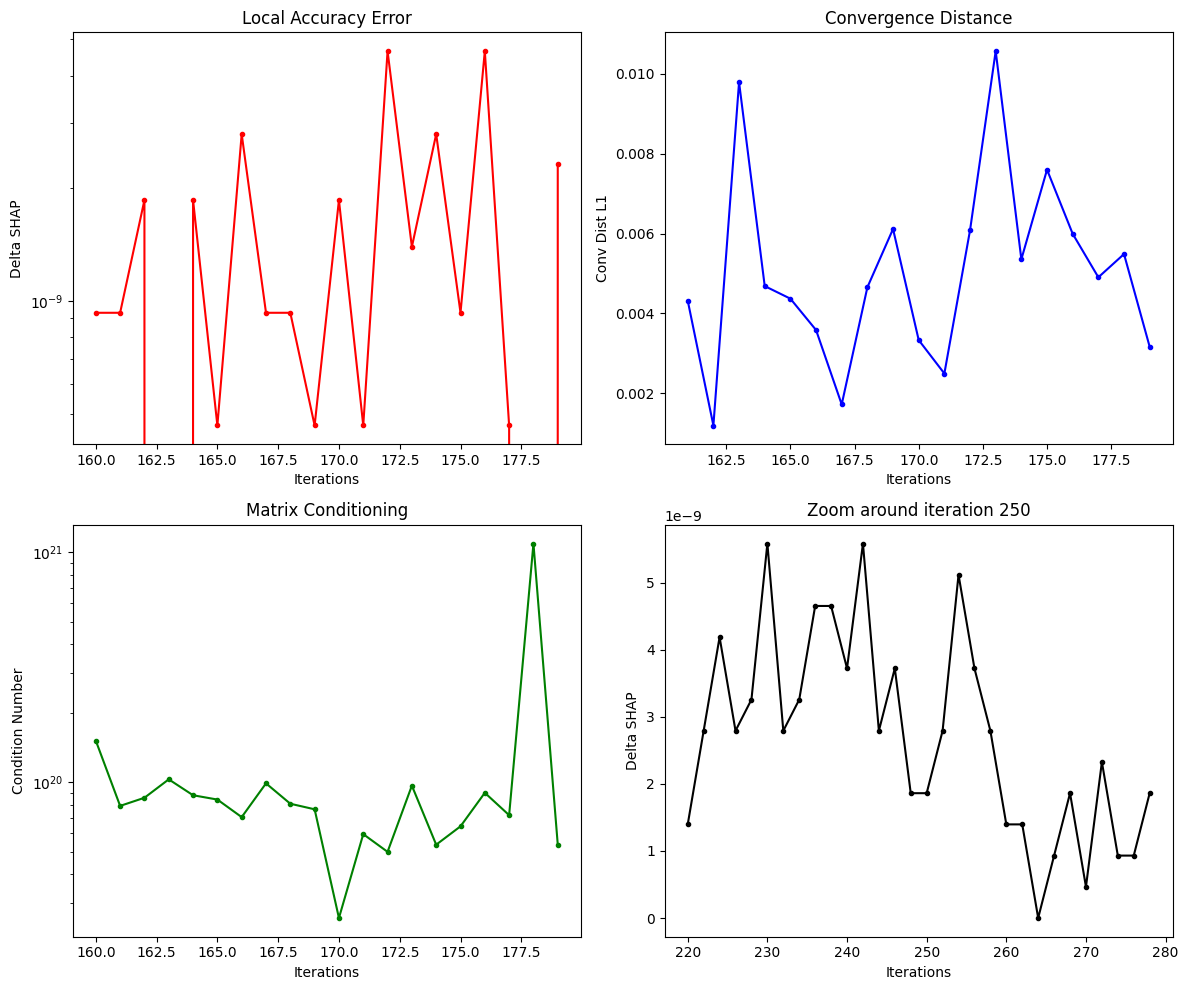


=== Additional Analysis ===
Number of unique samples: 3837
Number of all-zero samples: 1
Number of all-one samples: 1

=== Sample Diversity ===
Samples with exactly 1 features active: 292
Samples with exactly 5 features active: 76
Samples with exactly 10 features active: 37
Samples with exactly 50 features active: 8
Samples with exactly 100 features active: 3
Samples with exactly 383 features active: 292

=== Samples around position 170 ===
Sample 160: sum=1, y=0.000000, w=1
Sample 161: sum=382, y=0.007218, w=1
Sample 162: sum=266, y=0.006843, w=1
Sample 163: sum=382, y=0.007214, w=1
Sample 164: sum=242, y=0.006244, w=1
Sample 165: sum=323, y=0.007096, w=1
Sample 166: sum=3, y=0.000000, w=1
Sample 167: sum=3, y=0.000000, w=1
Sample 168: sum=360, y=0.007217, w=1
Sample 169: sum=380, y=0.007214, w=1
Sample 170: sum=383, y=0.007214, w=1
Sample 171: sum=329, y=0.007083, w=1
Sample 172: sum=199, y=0.000186, w=1
Sample 173: sum=7, y=0.000000, w=1
Sample 174: sum=367, y=0.007172, w=1
Sample 

In [56]:
# Plot analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Delta over iterations
axes[0,0].plot(checkpoints, deltas, 'r.-')
axes[0,0].set_xlabel('Iterations')
axes[0,0].set_ylabel('Delta SHAP')
axes[0,0].set_yscale('log')
axes[0,0].set_title('Local Accuracy Error')

# Convergence distance
if conv_distances:
    axes[0,1].plot(checkpoints[1:], conv_distances, 'b.-')
    axes[0,1].set_xlabel('Iterations')
    axes[0,1].set_ylabel('Conv Dist L1')
    axes[0,1].set_title('Convergence Distance')

# Condition numbers
axes[1,0].plot(checkpoints, condition_numbers, 'g.-')
axes[1,0].set_xlabel('Iterations')
axes[1,0].set_ylabel('Condition Number')
axes[1,0].set_yscale('log')
axes[1,0].set_title('Matrix Conditioning')

# Investigate around iteration 250
print("\n=== Investigating around iteration 250==")
window = list(range(220, 280, 2))  # every 2 iterations to save time
deltas_window = []
for n in window:
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])
    
    delta = abs(y[0].item() - (phi0 + phis.sum().item()))
    deltas_window.append(delta)

axes[1,1].plot(window, deltas_window, 'k.-')
axes[1,1].set_xlabel('Iterations')
axes[1,1].set_ylabel('Delta SHAP')
axes[1,1].set_title('Zoom around iteration 250')

plt.tight_layout()
plt.show()

# Check specific properties
print("\n=== Additional Analysis ===")
print(f"Number of unique samples: {len(torch.unique(X, dim=0))}")
print(f"Number of all-zero samples: {(X.sum(dim=1) == 0).sum()}")
print(f"Number of all-one samples: {(X.sum(dim=1) == X.shape[1]).sum()}")

# Check sample diversity
print(f"\n=== Sample Diversity ===")
for k in [1, 5, 10, 50, 100, 383]:
    mask_k = (X.sum(dim=1) == k)
    print(f"Samples with exactly {k} features active: {mask_k.sum()}")

# Look for the problematic sample around 170
print(f"\n=== Samples around position 170 ===")
for i in range(160, 180):
    print(f"Sample {i}: sum={X[i].sum():.0f}, y={y[i]:.6f}, w={w[i]:.0f}")

# Check if there are any extreme outliers in outputs
print(f"\n=== Output distribution ===")
sorted_outputs = torch.sort(y)[0]
print(f"Min 5 outputs: {sorted_outputs[:5]}")
print(f"Max 5 outputs: {sorted_outputs[-5:]}")

In [57]:
print("174th sample: ", X[174], y[174].item(), w[174].item())


174th sample:  tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1

In [58]:
print("index of the only 0 feature: ", (X[174] == 0).nonzero(as_tuple=True)[0].item())

RuntimeError: a Tensor with 17 elements cannot be converted to Scalar


n=   1: phi299=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phi299=0.000034, phi0=-0.000000, sum(phis)=0.007214

n=  11: phi299=0.000057, phi0=0.000000, sum(phis)=0.007214

n=  16: phi299=0.000056, phi0=-0.000000, sum(phis)=0.007214

n=  21: phi299=0.000062, phi0=-0.000000, sum(phis)=0.007214

n=  26: phi299=0.000030, phi0=0.000000, sum(phis)=0.007214

n=  31: phi299=-0.000005, phi0=-0.000000, sum(phis)=0.007214

n=  36: phi299=0.000004, phi0=-0.000000, sum(phis)=0.007214

n=  41: phi299=0.000005, phi0=0.000000, sum(phis)=0.007214

n=  46: phi299=0.000001, phi0=-0.000000, sum(phis)=0.007214

n=  51: phi299=0.000006, phi0=0.000000, sum(phis)=0.007214

n=  56: phi299=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  61: phi299=0.000029, phi0=-0.000000, sum(phis)=0.007214

n=  66: phi299=0.000028, phi0=-0.000000, sum(phis)=0.007214

n=  71: phi299=0.000036, phi0=0.000000, sum(phis)=0.007214

n=  76: phi299=0.000021, phi0=-0.000000, sum(phis)=0.007214

n=  81: phi299=0.000034, phi0

Text(0.5, 1.0, 'Coefficient of 299th feature over iterations')

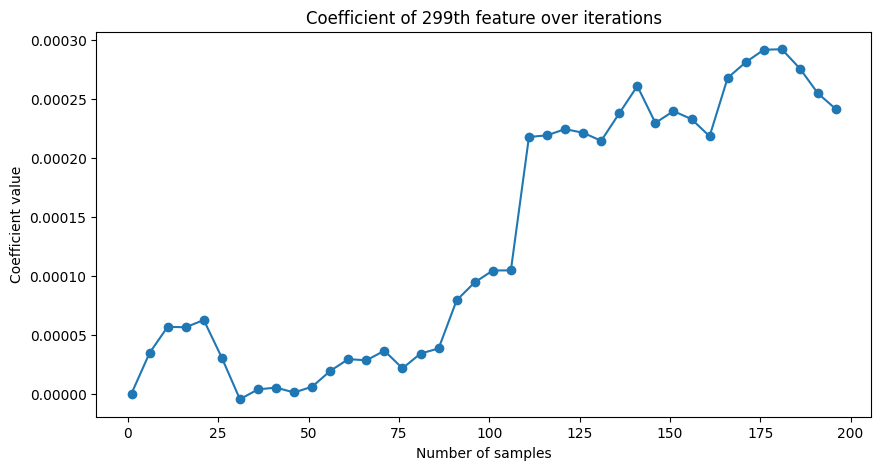

In [ ]:
# examine model weight of the 299th feature from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phi299={phis[299].item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save\ the coefficient of the 299th feature
    phis_v.append(phis[299].item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Coefficient of 299th feature over iterations')


n=   1: phiavg=0.000000, phi0=0.007214, sum(phis)=0.000000

n=   6: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  11: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  16: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  21: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  26: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  31: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  36: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  41: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  46: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  51: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  56: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  61: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  66: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  71: phiavg=0.000019, phi0=0.000000, sum(phis)=0.007214

n=  76: phiavg=0.000019, phi0=-0.000000, sum(phis)=0.007214

n=  81: phiavg=0.000019, phi0=

Text(0.5, 1.0, 'Average coefficient of features over iterations')

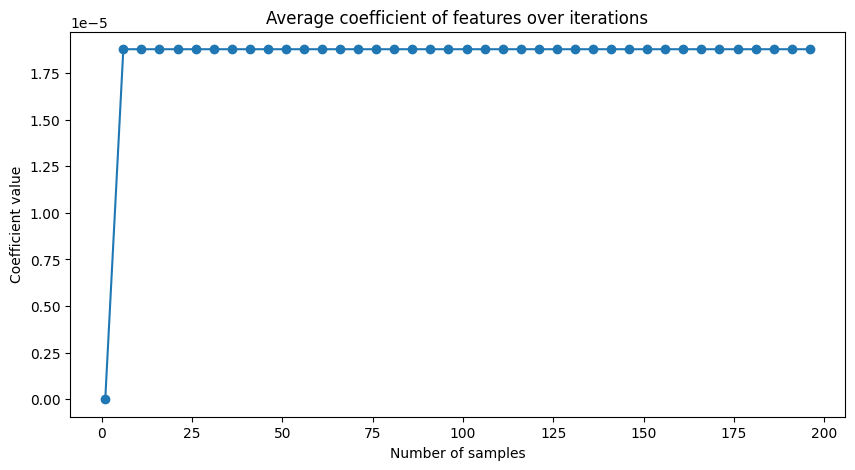

In [ ]:
# examine model weight of the average of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    print(f"\nn={n:4d}: phiavg={phis.mean().item():.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

    # save the average coefficient
    phis_v.append(phis.mean().item())

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints, phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Average coefficient of features over iterations')


n=   6: phi299=0.000034, phi0=-0.000000, sum(phis)=0.007214

n=  11: phi299=0.000022, phi0=0.000000, sum(phis)=0.007214

n=  16: phi299=-0.000000, phi0=-0.000000, sum(phis)=0.007214

n=  21: phi299=0.000006, phi0=-0.000000, sum(phis)=0.007214

n=  26: phi299=-0.000032, phi0=0.000000, sum(phis)=0.007214

n=  31: phi299=-0.000035, phi0=-0.000000, sum(phis)=0.007214

n=  36: phi299=0.000008, phi0=-0.000000, sum(phis)=0.007214

n=  41: phi299=0.000002, phi0=0.000000, sum(phis)=0.007214

n=  46: phi299=-0.000004, phi0=-0.000000, sum(phis)=0.007214

n=  51: phi299=0.000005, phi0=0.000000, sum(phis)=0.007214

n=  56: phi299=0.000013, phi0=0.000000, sum(phis)=0.007214

n=  61: phi299=0.000010, phi0=-0.000000, sum(phis)=0.007214

n=  66: phi299=-0.000001, phi0=-0.000000, sum(phis)=0.007214

n=  71: phi299=0.000008, phi0=0.000000, sum(phis)=0.007214

n=  76: phi299=-0.000015, phi0=-0.000000, sum(phis)=0.007214

n=  81: phi299=0.000013, phi0=-0.000000, sum(phis)=0.007214

n=  86: phi299=0.000004

Text(0.5, 1.0, 'Variation of the coefficient of 299th feature over iterations')

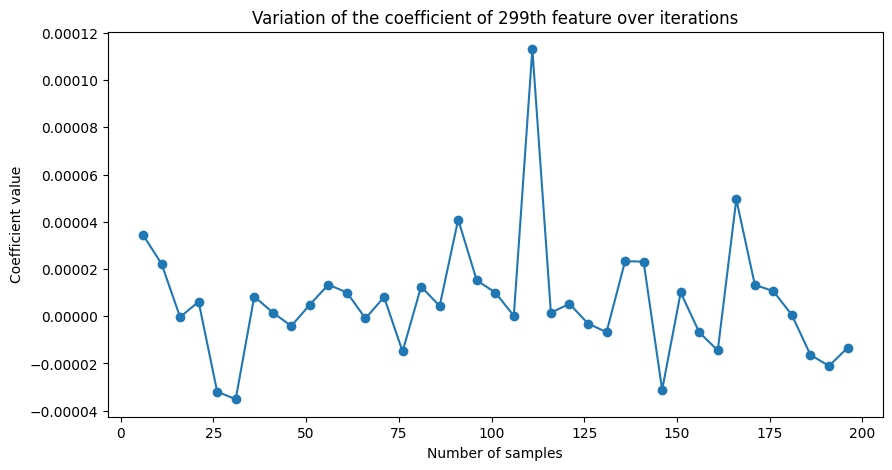

In [ ]:
# examine model weight differences of the features from 0 to the 200th sample
checkpoints = range(1,201,5)
phis_v = []
idx = 299  # index of the feature to analyze
phi_prev = None
for n in checkpoints:
    # Fit model with first n samples\
    surrogate = LinReg()
    subset = Subset(ds, range(n))
    X_batch, y_batch, w_batch = next(iter(DataLoader(subset, batch_size=n)))
    surrogate.fit(X_batch.numpy(), y_batch.numpy(), sample_weight=w_batch.numpy())
    
    # Get coefficients
    phis = torch.as_tensor(surrogate.coef_, dtype=torch.float32).flatten()
    phi0 = surrogate.intercept_  # intercept
    beta = torch.cat([torch.tensor([phi0], dtype=torch.float32), phis])

    if phi_prev is not None:
        phi = phis[idx] - phi_prev
        print(f"\nn={n:4d}: phi299={phi:.6f}, phi0={phi0:.6f}, sum(phis)={phis.sum().item():.6f}")

        # save the coefficient of the 299th feature
        phis_v.append(phi.item())
    
    phi_prev = phis[idx].clone()

# Plot the coefficients of the 299th feature
plt.figure(figsize=(10, 5))
plt.plot(checkpoints[1:], phis_v, marker='o', label='Coefficient of 299th feature')
plt.xlabel('Number of samples')
plt.ylabel('Coefficient value')
plt.title('Variation of the coefficient of 299th feature over iterations')